In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    brier_score_loss,
    log_loss,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [2]:
df1 = pd.read_csv("../output/shots_training_data_Germany.csv")
df2 = pd.read_csv("../output/shots_training_data_uefa.csv")
df3 = pd.read_csv("../output/shots_training_data_France.csv")
df4 = pd.read_csv("../output/shots_training_data_Spain.csv")
df5 = pd.read_csv("../output/shots_training_data_Italy.csv")
df6 = pd.read_csv("../output/shots_training_data_England.csv")

df = pd.concat([df1, df2, df3, df4, df5, df6])

In [3]:
df = df[df["shot_type"] != "Penalty"]

X = df[["distance", "angle", "body_part", "technique", "shot_type",
         "play_pattern", "num_teammates", "num_opponents"]]
y = df["goal"]

numeric_features = ["distance", "angle", "num_teammates", "num_opponents"]
categorical_features = ["body_part", "technique", "shot_type", "play_pattern"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop",
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [4]:
# compare 4 models LR/DT/RF/XGB
models_4 = {
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        n_estimators=400,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1,
        tree_method="hist",
    ),
}


def eval_model(name, clf):
    pipe = Pipeline([("prep", preprocessor), ("clf", clf)])
    pipe.fit(X_train, y_train)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    return {
        "Model": name,
        "AUC": roc_auc_score(y_test, y_prob),
        "AP (PR-AUC)": average_precision_score(y_test, y_prob),
        "LogLoss": log_loss(y_test, y_prob),
        "Brier": brier_score_loss(y_test, y_prob),
        "Accuracy": accuracy_score(y_test, y_pred),
    }


df_cmp4 = (
    pd.DataFrame([eval_model(n, m) for n, m in models_4.items()])
    .sort_values("AUC", ascending=False)
    .reset_index(drop=True)
)

print(df_cmp4.to_string(index=False))

             Model      AUC  AP (PR-AUC)  LogLoss    Brier  Accuracy
LogisticRegression 0.798299     0.369798 0.253864 0.071554  0.910657
           XGBoost 0.791252     0.354342 0.257727 0.072509  0.911721
      RandomForest 0.743558     0.289422 0.347678 0.079045  0.907041
      DecisionTree 0.594078     0.135165 5.344208 0.148320  0.851521


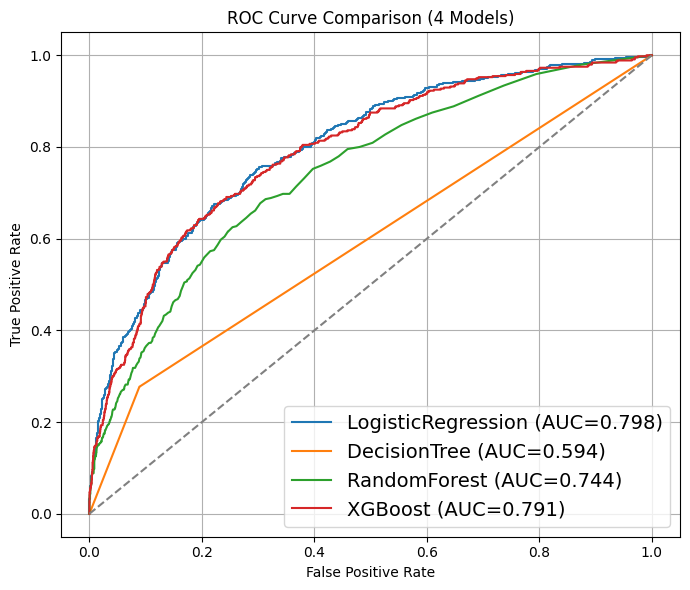

In [5]:
# compare models in ROC
plt.figure(figsize=(7,6))

for name, clf in {
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(
        n_estimators=400, max_depth=5, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.8, reg_lambda=1.0,
        objective="binary:logistic", eval_metric="logloss",
        random_state=42, n_jobs=-1, tree_method="hist"
    ),
}.items():
    pipe = Pipeline([("prep", preprocessor), ("clf", clf)])
    pipe.fit(X_train, y_train)
    y_prob = pipe.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], "--", color="gray")

plt.title("ROC Curve Comparison (4 Models)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()